In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.integrate as spi
plt.style.use('seaborn-white')
%matplotlib inline

In [2]:
filename = 'data/curved_diff_lambdas.csv'
df = pd.read_csv(filename)
df.head()

,DL,DLS,DS,numerical_thetas,om_k,om_lambdas,step,theta
0,196.760858,22.460452,218.106508,0.00001,0.0,0.000000,5.000000e-07,0.00001
1,197.441297,22.342781,218.677892,0.00001,0.0,0.098889,5.000000e-07,0.00001
2,198.131168,22.221375,219.265529,0.00001,0.0,0.197778,5.000000e-07,0.00001
3,198.830718,22.095982,219.839694,0.00001,0.0,0.296667,5.000000e-07,0.00001
4,199.540204,21.966565,220.436211,0.00001,0.0,0.395556,5.000000e-07,0.00001


In [3]:
# # patch
# length_scale = 3.086e22
# H_0 = 7.56e-27 * length_scale
# M = 1474e12 / length_scale

# z_lens1 = np.linspace(0.05, 0.2, 100)
# z_lens2 = []
# for z in z_lens1:
#     z_lens2.extend([z]*50)

# # print(len(z_lens2), len(df.index))
# df['z_lens'] = z_lens2[:len(df.index)]

# def get_distances(z, Omega_Lambda=0):
#     Omega_m = 1 - Omega_Lambda
#     def integrand(z):
#         return 1/np.sqrt(Omega_m*(1+z)**3 + Omega_Lambda)
#     integral, error = spi.quad(integrand, 0, z)
#     comoving = integral/H_0
#     dang = comoving/(1+z)
#     return comoving, dang

# dang_lens = []
# for index, row in df.iterrows():
#     com, dang = get_distances(row.z_lens, row.om_lambdas)
#     dang_lens.append(dang)

# df['DL'] = dang_lens

In [4]:
# df = df[~((df.om_lambdas < 0.707144) & (df.om_lambdas > 0.707142))]

length_scale = 3.086e22
H_0 = 7.56e-27 * length_scale
M = 1474e12 / length_scale

def calc_theta(D_LS, D_L, D_S):
    return np.sqrt(4*M*D_LS/D_L/D_S)

theta_second_order = []
theta_rindler = []
for index, row in df.iterrows():
    Lambda = 3*row.om_lambdas*H_0**2
    coeff = [row.DLS*Lambda*row.DL**3/6/M, row.DS, -4*M*row.DLS/row.DL, 8*M**3*row.DLS/row.DL**3]
    roots = np.roots(coeff)
    roots = roots[roots>0]
    th = np.sqrt(roots)
    rindler = th[np.argmin(row.theta - th)]
    
    coeff2 = [row.DS, -4*M*row.DLS/row.DL, 8*M**3*row.DLS/row.DL**3]
    roots2 = np.roots(coeff2)
    roots2 = roots2[roots2>0]
    th2 = np.sqrt(roots2)
    second_order = th2[np.argmin(row.theta - th2)]
    theta_rindler.append(rindler)
    theta_second_order.append(second_order)

df['theta_second_order'] = theta_second_order
df['theta_rindler'] = theta_rindler


# ## removed percentage!!

df['percentage_diff'] = (df.theta_second_order - df.theta)/df.theta
df['rindler_preds'] = (df.theta_rindler - df.theta)/df.theta

# df['percentage_diff'] = (df.theta_second_order - df.theta)/df.theta*100
# df['percentage_diff'] = (df.rs - df.rs_initial)/df.rs_initial*100

In [5]:
df.head()

,DL,DLS,DS,numerical_thetas,om_k,om_lambdas,step,theta,theta_second_order,theta_rindler,percentage_diff,rindler_preds
0,196.760858,22.460452,218.106508,0.00001,0.0,0.000000,5.000000e-07,0.00001,0.00001,0.00001,-0.000031,-0.000031
1,197.441297,22.342781,218.677892,0.00001,0.0,0.098889,5.000000e-07,0.00001,0.00001,0.00001,-0.000028,-0.000030
2,198.131168,22.221375,219.265529,0.00001,0.0,0.197778,5.000000e-07,0.00001,0.00001,0.00001,-0.000048,-0.000052
3,198.830718,22.095982,219.839694,0.00001,0.0,0.296667,5.000000e-07,0.00001,0.00001,0.00001,-0.000025,-0.000031
4,199.540204,21.966565,220.436211,0.00001,0.0,0.395556,5.000000e-07,0.00001,0.00001,0.00001,-0.000038,-0.000047


In [6]:
stats = df[['om_lambdas', 'percentage_diff', 'rindler_preds']].groupby('om_lambdas').agg(['mean', 'std', 'count'])
stats.columns = [' '.join(col).strip() for col in stats.columns.values]
stats['percentage_diff mean std'] = stats['percentage_diff std']/np.sqrt(stats['percentage_diff count'])
stats['rindler_preds mean std'] = stats['rindler_preds std']/np.sqrt(stats['rindler_preds count'])
stats

,percentage_diff mean,percentage_diff std,percentage_diff count,rindler_preds mean,rindler_preds std,rindler_preds count,percentage_diff mean std,rindler_preds mean std
om_lambdas,,,,,,,,
0.000000,3.354095e-06,0.000037,10,0.000003,0.000037,10,0.000012,0.000012
0.098889,-7.759756e-06,0.000026,10,-0.000086,0.000090,10,0.000008,0.000028
0.197778,-1.206468e-05,0.000053,10,-0.000171,0.000140,10,0.000017,0.000044
0.296667,-1.778137e-05,0.000041,10,-0.000260,0.000220,10,0.000013,0.000070
0.395556,1.969466e-07,0.000032,10,-0.000328,0.000316,10,0.000010,0.000100
0.494444,-2.610076e-05,0.000029,10,-0.000442,0.000409,10,0.000009,0.000129
0.593333,-2.111955e-05,0.000043,10,-0.000527,0.000522,10,0.000014,0.000165
0.692222,-2.091100e-05,0.000041,10,-0.000621,0.000616,10,0.000013,0.000195
0.791111,-2.746256e-05,0.000020,10,-0.000723,0.000708,10,0.000006,0.000224


<Container object of 3 artists>

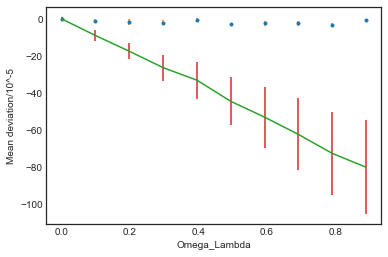

In [10]:
scale = 1e-5
plt.plot(stats.index, stats['percentage_diff mean']/scale, '.')
plt.errorbar(stats.index, stats['percentage_diff mean']/scale, yerr=stats['percentage_diff mean std']/scale, linestyle='none')
plt.xlabel('Omega_Lambda')
plt.ylabel('Mean deviation/10^-5')
plt.plot(stats.index, stats['rindler_preds mean']/scale)
plt.errorbar(stats.index, stats['rindler_preds mean']/scale, yerr=stats['rindler_preds mean std']/scale, linestyle='none')

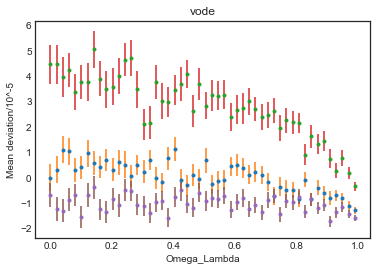

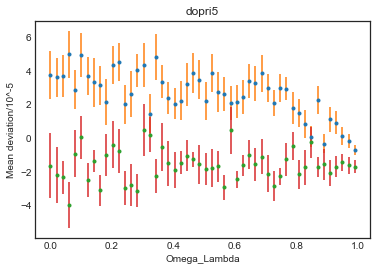

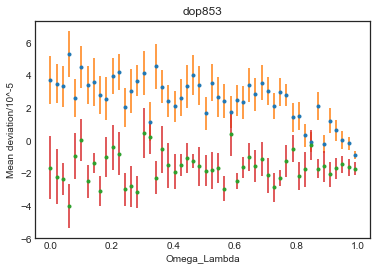

In [8]:
from util import plot_diff_lambdas
plt.figure()
plt.title("vode")
plot_diff_lambdas('data/diff_lambdas_small2.csv', recalculate_distances=True)
plot_diff_lambdas('data/diff_lambdas_step.csv')
plot_diff_lambdas('data/diff_lambdas_step2.csv')
plt.figure()
plt.title("dopri5")
plot_diff_lambdas('data/dopri5_diff_lambdas.csv')
plot_diff_lambdas('data/dopri5_diff_lambdas2.csv')
plt.figure()
plt.title("dop853")
plot_diff_lambdas('data/dop853_diff_lambdas.csv')
plot_diff_lambdas('data/dop853_diff_lambdas2.csv')